In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("/Users/tylersong/Desktop/school/ML/ML-Final-Project")
from utils import grid_evaluate


#Load the saved CSVs
X_train = pd.read_csv('../X_train.csv')
X_test = pd.read_csv('../X_test.csv')
y_train = pd.read_csv('../y_train.csv')
y_test = pd.read_csv('../y_test.csv')

#Squeeze to make them Series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

#Verify shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(747, 28)
(250, 28)
(747,)
(250,)


In [2]:
# One iteration testing
# svm_clf = SVC(
#     kernel='linear',       # radial basis function kernel
#     C=1.0,              # regularization parameter; try grid‐search to tune
#     gamma='scale',      # 'scale' is 1 / (n_features * X.var())
#     probability=True,   # enable .predict_proba() for ROC/AUC
#     random_state=42
# )
# svm_clf.fit(X_train, y_train)

# y_pred    = svm_clf.predict(X_test)
# y_proba   = svm_clf.predict_proba(X_test)[:,1]


svm = LinearSVC(max_iter=3000, random_state=42)


param_grid = {
    'feature_method': [None, 'polynomial', 'pca', 'rbf'],
    'degree':         [2, 3],
    'n_components':   [5, 10],
    'gamma':          [0.1, 0.5],
    'C':              [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
}

results = grid_evaluate(
    estimator  = svm,
    param_grid = param_grid,
    X_train    = X_train,
    X_test     = X_test,
    y_train    = y_train,
    y_test     = y_test
)
#drop unnecessary columns (neural network columns)
results = results.drop(
    columns=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    errors='ignore'   # won’t error out if any are already missing
)

# best by F1
best = results.sort_values('f1_test', ascending=False)
print(best)
print(best.iloc[0])

Evaluated 5 parameter combinations...
Evaluated 10 parameter combinations...
Evaluated 15 parameter combinations...
Evaluated 20 parameter combinations...
Evaluated 25 parameter combinations...
Evaluated 30 parameter combinations...
Evaluated 35 parameter combinations...
Evaluated 40 parameter combinations...
Evaluated 45 parameter combinations...
Evaluated 50 parameter combinations...
Evaluated 55 parameter combinations...
Evaluated 60 parameter combinations...
Evaluated 65 parameter combinations...
Evaluated 70 parameter combinations...
Evaluated 75 parameter combinations...
Evaluated 80 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 85 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 90 parameter combinations...
Evaluated 95 parameter combinations...
Evaluated 100 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 105 parameter combinations...
Evaluated 110 parameter combinations...
Evaluated 115 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 120 parameter combinations...
Evaluated 125 parameter combinations...
Evaluated 130 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 135 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 140 parameter combinations...
Evaluated 145 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 150 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 155 parameter combinations...
Evaluated 160 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 165 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 170 parameter combinations...
Evaluated 175 parameter combinations...
Evaluated 180 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluated 185 parameter combinations...
Evaluated 190 parameter combinations...
   feature_method  degree  n_components  gamma  accuracy_test  accuracy_train  \
39     polynomial       2            10    0.5          0.760        0.864793   
38     polynomial       2             5    0.5          0.760        0.864793   
37     polynomial       2            10    0.1          0.760        0.864793   
36     polynomial       2             5    0.1          0.760        0.864793   
23     polynomial       3            10    0.5          0.760        0.906292   
..            ...     ...           ...    ...            ...             ...   
15            rbf       1            10    0.5          0.752        0.767068   
14            rbf       1             5    0.5          0.752        0.767068   
12            rbf       1             5    0.1          0.752        0.767068   
13            rbf       1            10    0.1          0.752        0.767068   
47            rbf       1    

In [3]:
best.to_csv('svm_results.csv', index=False)
print("Saved results to svm_results.csv")

Saved results to svm_results.csv


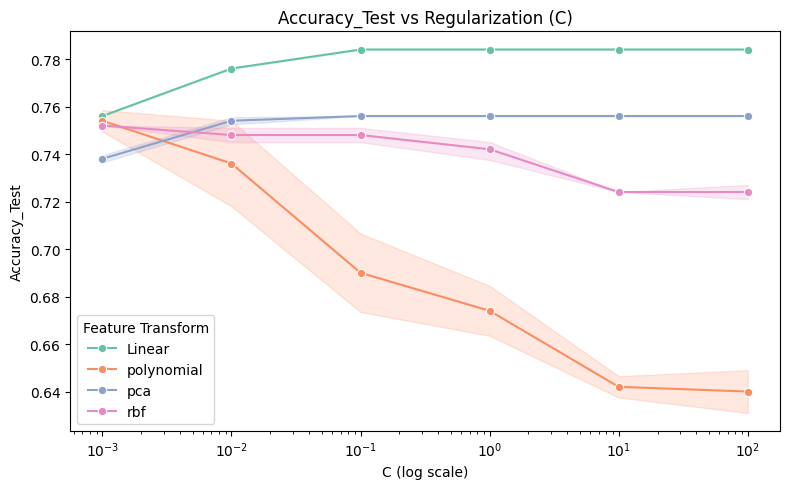

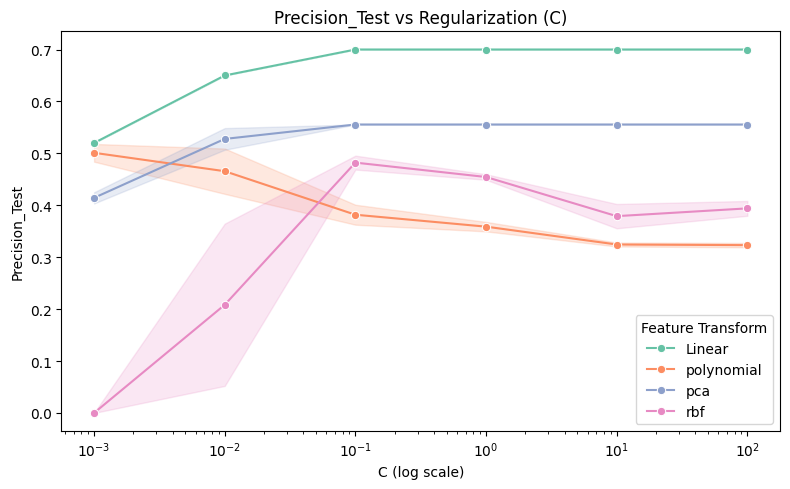

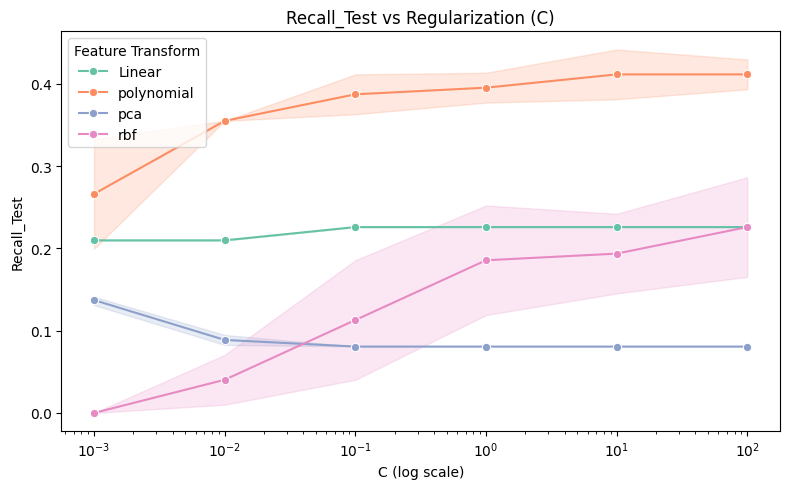

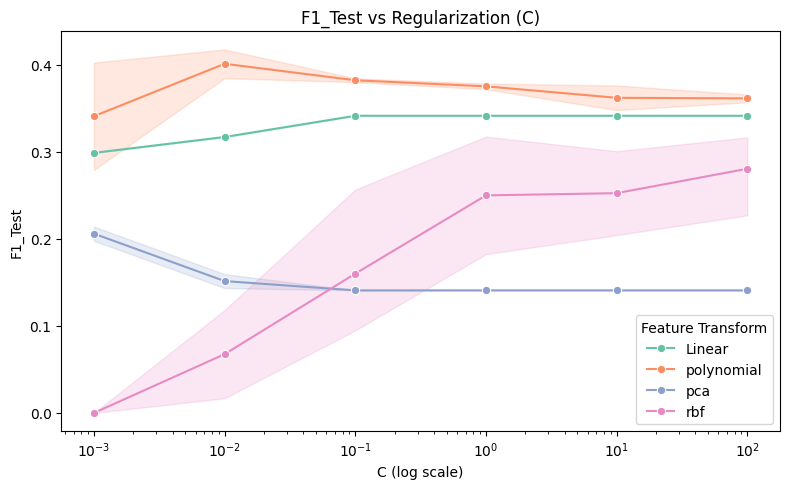

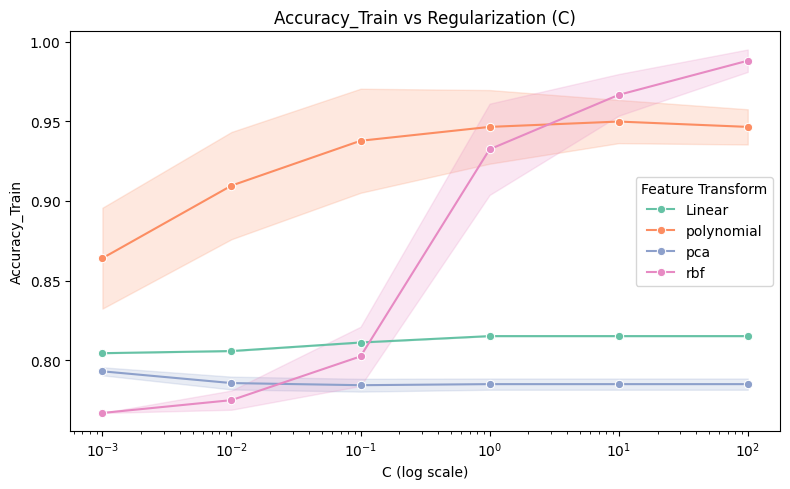

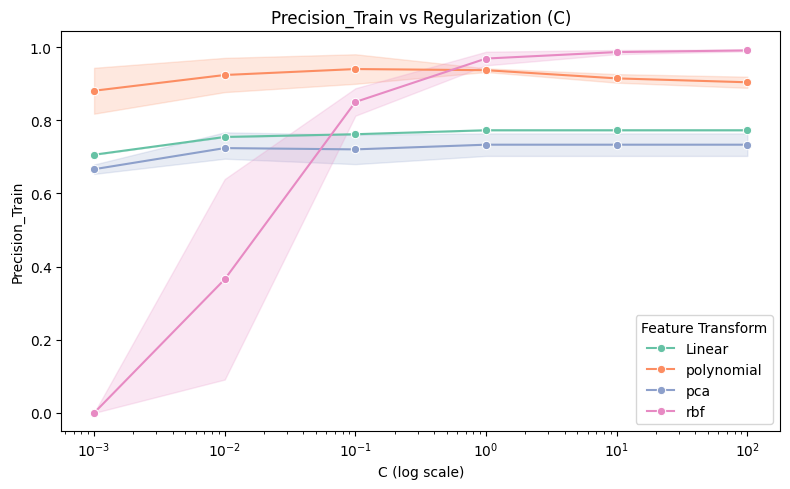

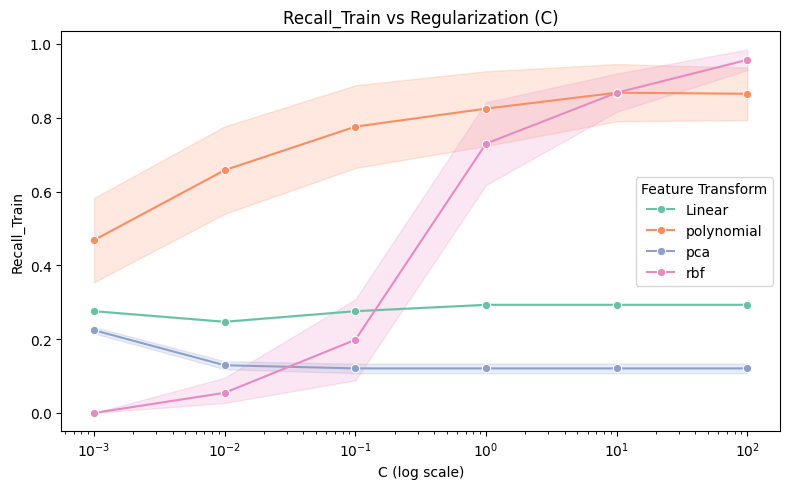

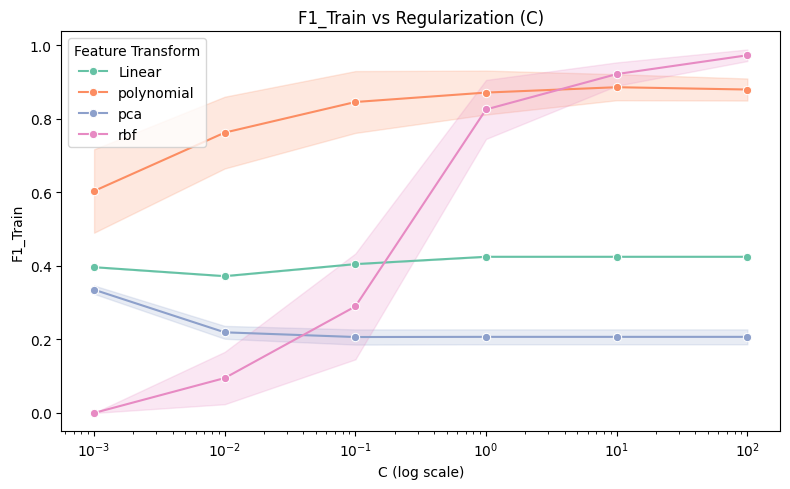

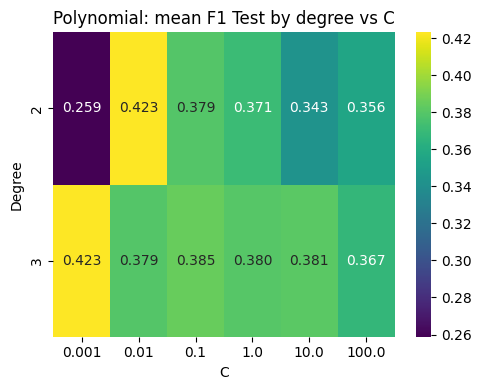

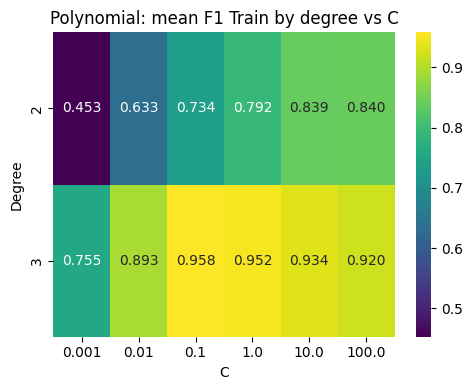

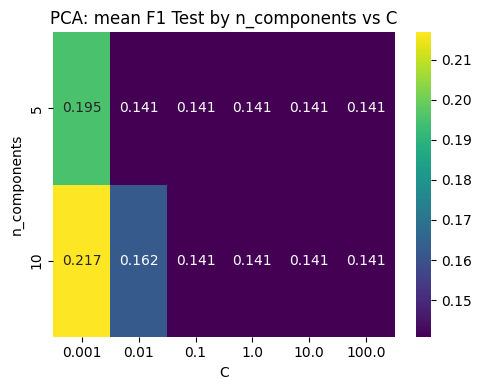

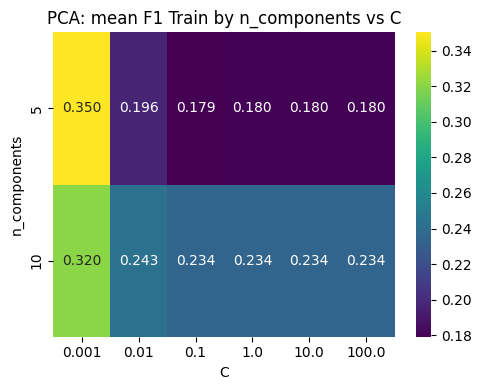

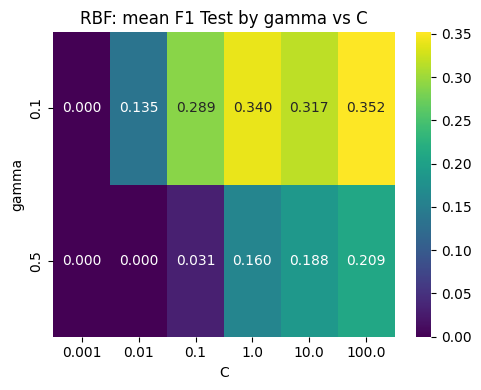

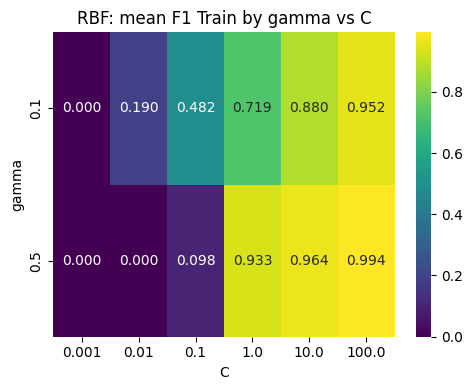

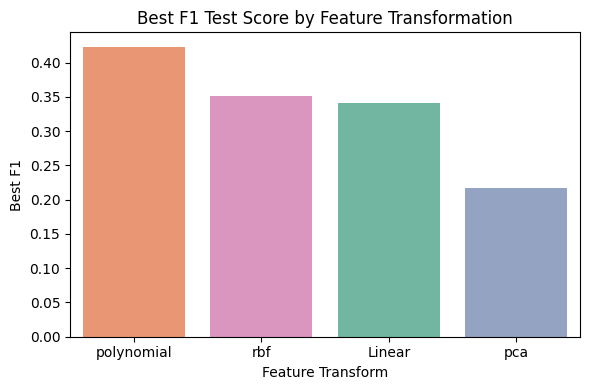

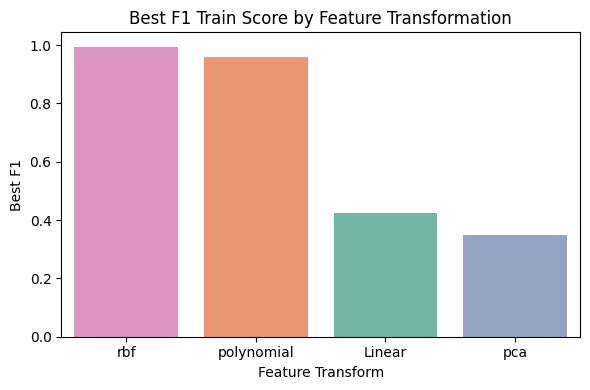

In [4]:
methods = ['Linear','polynomial','pca','rbf']
colors  = sns.color_palette("Set2", n_colors=len(methods))  # or any palette you like
fixed_palette = dict(zip(methods, colors))

#Line‐plots of each metric vs C (unchanged)


metrics = ['accuracy_test','precision_test','recall_test','f1_test', 'accuracy_train','precision_train','recall_train','f1_train']
for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data   = results,
        x      = 'C',
        y      = metric,
        hue    = 'feature_method',
        palette = fixed_palette,
        marker = 'o'
    )
    plt.xscale('log')
    plt.title(f'{metric.title()} vs Regularization (C)')
    plt.ylabel(metric.title())
    plt.xlabel('C (log scale)')
    plt.legend(title='Feature Transform')
    plt.tight_layout()
    plt.show()


#Heatmap for Polynomial: mean F1 by degree vs C
poly = results[results['feature_method']=='polynomial']
if not poly.empty:
    pivot_poly = poly.pivot_table(
        index='degree',
        columns='C',
        values='f1_test',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_poly, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('Polynomial: mean F1 Test by degree vs C')
    plt.ylabel('Degree')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

poly = results[results['feature_method']=='polynomial']
if not poly.empty:
    pivot_poly = poly.pivot_table(
        index='degree',
        columns='C',
        values='f1_train',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_poly, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('Polynomial: mean F1 Train by degree vs C')
    plt.ylabel('Degree')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()


#Heatmap for PCA: mean F1 by n_components vs C
pca = results[results['feature_method']=='pca']
if not pca.empty:
    pivot_pca = pca.pivot_table(
        index='n_components',
        columns='C',
        values='f1_test',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_pca, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('PCA: mean F1 Test by n_components vs C')
    plt.ylabel('n_components')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

pca = results[results['feature_method']=='pca']
if not pca.empty:
    pivot_pca = pca.pivot_table(
        index='n_components',
        columns='C',
        values='f1_train',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_pca, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('PCA: mean F1 Train by n_components vs C')
    plt.ylabel('n_components')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

#Heatmap for RBF: mean F1 by gamma vs C
rbf = results[results['feature_method']=='rbf']
if not rbf.empty:
    pivot_rbf = rbf.pivot_table(
        index='gamma',
        columns='C',
        values='f1_test',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_rbf, annot=True, fmt='.3f', cmap='viridis', )
    plt.title('RBF: mean F1 Test by gamma vs C')
    plt.ylabel('gamma')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

rbf = results[results['feature_method']=='rbf']
if not rbf.empty:
    pivot_rbf = rbf.pivot_table(
        index='gamma',
        columns='C',
        values='f1_train',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_rbf, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('RBF: mean F1 Train by gamma vs C')
    plt.ylabel('gamma')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

#test
best_per = (
    results
    .groupby('feature_method', as_index=False)
    ['f1_test']
    .max()
    .sort_values('f1_test', ascending=False)
)

plt.figure(figsize=(6,4))
ax = sns.barplot(
    data    = best_per,
    x       = 'feature_method',
    y       = 'f1_test',
    hue     = 'feature_method',  
    dodge   = False,              
    palette = fixed_palette,
)
legend = ax.get_legend()
if legend is not None:
    legend.remove()


plt.title('Best F1 Test Score by Feature Transformation')
plt.ylabel('Best F1')
plt.xlabel('Feature Transform')
plt.tight_layout()
plt.show()


#train
best_per = (
    results
    .groupby('feature_method', as_index=False)
    ['f1_train']
    .max()
    .sort_values('f1_train', ascending=False)
)

plt.figure(figsize=(6,4))
ax = sns.barplot(
    data    = best_per,
    x       = 'feature_method',
    y       = 'f1_train',
    hue     = 'feature_method',  
    dodge   = False,              
    palette = fixed_palette,
)
legend = ax.get_legend()
if legend is not None:
    legend.remove()


plt.title('Best F1 Train Score by Feature Transformation')
plt.ylabel('Best F1')
plt.xlabel('Feature Transform')
plt.tight_layout()
plt.show()
